# **DATASET COLUMNS: Date,Consumption,Wind,Solar,Wind_Solar**

FROM GITHUB I DIRECTLY LOADED THE TIME-SERIES DATASET AND PERFORMED VARIOUS OPERATIONS ON THAT DATASET

# **PART - A (RNN IMPLEMENTATION)**

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [2]:
import pandas as pd
import numpy as np

In [3]:
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

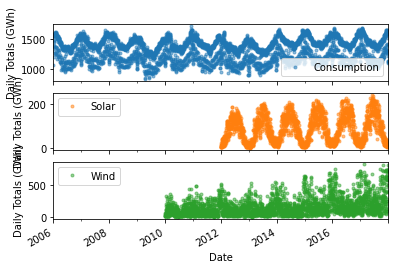

In [4]:
cols_plot = ['Consumption', 'Solar', 'Wind']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

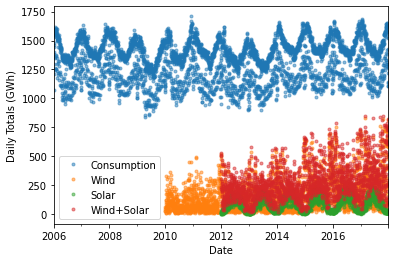

In [5]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (GWh)');

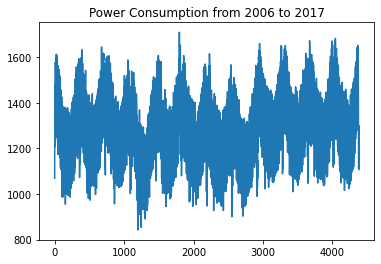

In [6]:
consumption = time_series_df['Consumption'].to_numpy()
plt.title('Power Consumption from 2006 to 2017')
plt.plot(consumption);

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


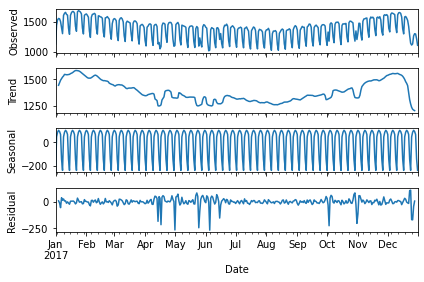

In [7]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(time_series_df['2017']['Consumption'], model='additive')
decomposition.plot();

In [8]:
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [9]:
n_steps_in = 15 
n_steps_out = 1

In [10]:
X, Y = split_sequence(consumption, n_steps_in, n_steps_out)
X.shape, Y.shape



((4353, 30), (4353, 1))

In [11]:
X, Y = split_sequence(consumption, n_steps_in, n_steps_out)
X.shape, Y.shape

((4353, 30), (4353, 1))

In [12]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(4353, 30, 1)

In [13]:
X_train = X[:-365]
Y_train = Y[:-365]

X_test = X[-365:]
Y_test = Y[-365:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((3988, 30, 1), (3988, 1), (365, 30, 1), (365, 1))

# **BASELINES**

In [14]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)
Y_pred_baseline_rolling = rolling_mean_baseline(X)
Y_pred_baseline_rolling.shape

(4353, 1)

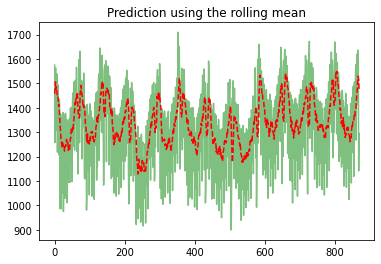

In [15]:
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_rolling[::stride], color='r', ls='dashed')

plt.title('Prediction using the rolling mean');

In [16]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_rolling)

0.2045281177663184

# **BASELINE: PREVIOUS**

In [55]:
def previous_value_baseline(history):
  return history[:, -1]

In [56]:
Y_pred_baseline_previous_value = previous_value_baseline(X)
Y_pred_baseline_previous_value.shape

(4353, 1)

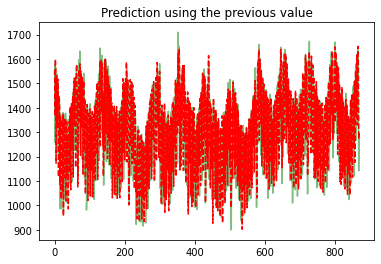

In [57]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[::stride], color='r', ls='dashed')
plt.title('Prediction using the previous value');

In [58]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_previous_value)

0.18305610815179707

# **Prediction using RNNs and TensorFlow**

RNN

In [49]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))

model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [50]:

batch_size = 32
epochs=15

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/15
125/125 [==============================] - 4s 24ms/step - loss: 108313.0078 - accuracy: 0.0000e+00 - val_loss: 14890.3633 - val_accuracy: 0.0000e+00
Epoch 2/15
125/125 [==============================] - 3s 20ms/step - loss: 7306.5068 - accuracy: 0.0000e+00 - val_loss: 4725.8955 - val_accuracy: 0.0000e+00
Epoch 3/15
125/125 [==============================] - 3s 21ms/step - loss: 4671.1665 - accuracy: 0.0000e+00 - val_loss: 4612.0415 - val_accuracy: 0.0000e+00
Epoch 4/15
125/125 [==============================] - 3s 21ms/step - loss: 4573.7700 - accuracy: 0.0000e+00 - val_loss: 4290.4014 - val_accuracy: 0.0000e+00
Epoch 5/15
125/125 [==============================] - 3s 21ms/step - loss: 4428.4370 - accuracy: 0.0000e+00 - val_loss: 4141.6450 - val_accuracy: 0.0000e+00
Epoch 6/15
125/125 [==============================] - 3s 21ms/step - loss: 4161.1870 - accuracy: 0.0000e+00 - val_loss: 3980.6277 - val_accuracy: 0.0000e+00
Epoch 7/15
125/125 [==============================] - 3

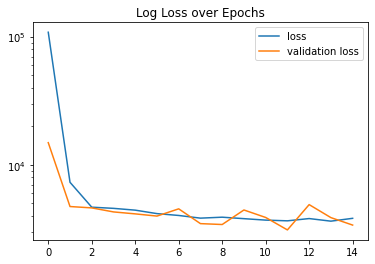

In [51]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

In [52]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[3537.88232421875, 0.0]

In [54]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

0.8696824099201392

# **QUESTION PART-B**

# IMPROVING THE RESULT 

# Overall a pretty good result

# -> r2 score is pretty promising

# -> Defintely improved over baseline


I HAVE DEFINED A FUNCTION R2-METRIC TO INCREASE THE ACCURACY OF THE MODEL .BY USING THIS FUNCTION IN THE RNN THE ACCURACY HAS CHANGED A BIT AND ITS VERY HIGH COMPARE TO BASELINE MODELS

In [36]:
def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()


# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))
# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 256)               66048     
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [38]:
batch_size = 32
epochs=20

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/20
125/125 [==============================] - 4s 22ms/step - loss: 51002.4102 - r2_metric: -0.9949 - val_loss: 16520.5078 - val_r2_metric: 0.1589
Epoch 2/20
125/125 [==============================] - 3s 20ms/step - loss: 8800.1953 - r2_metric: 0.6548 - val_loss: 5136.7764 - val_r2_metric: 0.7308
Epoch 3/20
125/125 [==============================] - 3s 21ms/step - loss: 5269.3037 - r2_metric: 0.7965 - val_loss: 4583.0024 - val_r2_metric: 0.7522
Epoch 4/20
125/125 [==============================] - 3s 21ms/step - loss: 5188.3911 - r2_metric: 0.7965 - val_loss: 5386.3481 - val_r2_metric: 0.7240
Epoch 5/20
125/125 [==============================] - 3s 21ms/step - loss: 4679.8306 - r2_metric: 0.8196 - val_loss: 3995.8965 - val_r2_metric: 0.7910
Epoch 6/20
125/125 [==============================] - 3s 21ms/step - loss: 4872.1313 - r2_metric: 0.8131 - val_loss: 3753.9976 - val_r2_metric: 0.8060
Epoch 7/20
125/125 [==============================] - 3s 21ms/step - loss: 4746.9634 - r2_m

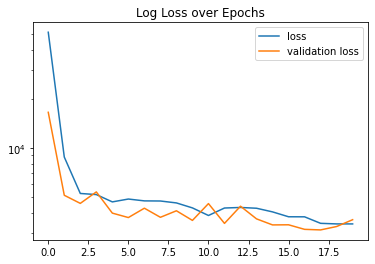

In [39]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

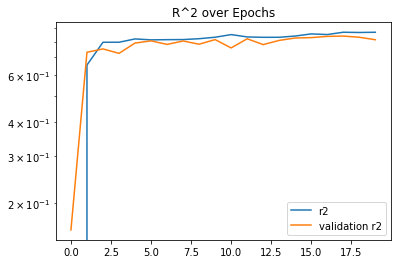

In [40]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [41]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[3491.534912109375, -inf]

In [42]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)

0.8726879248895066

In [43]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

0.8723949719316513

In [44]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

0.8655255647102914

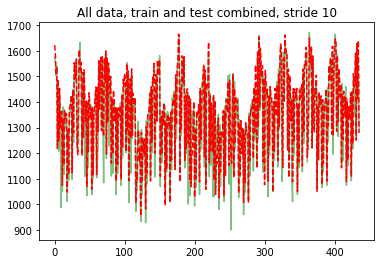

In [45]:
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


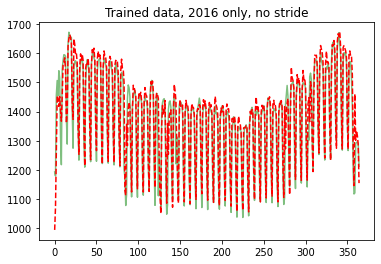

In [46]:
stride = 1


plt.plot(consumption[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2016 only, no stride');


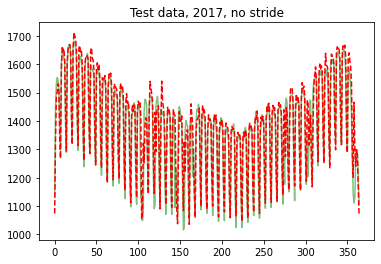

In [47]:
stride = 1


plt.plot(consumption[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2017, no stride');
